## Model parameters selection

Select the parameters for Unet architecture to find first break picking time on the seismic trace.

* [The parameters studied](#The-parameters-studied)
* [Parameters value area](#Parameters-value-area)
* [Metrics](#Metrics)
* [Dataset loading](#Dataset-loading)
* [Dataset bypass](#Dataset-bypass)
* [Creating a research object](#Creating-a-research-object)
* [Results](#Results)
* [Conclusion](#Conclusion)

    
### The parameters studied
The number of UNet blocks and the number of filters and kernel size for encoder convolutions.

### Parameters value area
* _Number of Unet blocks_ - 4, 5, 7.

* _Encoder convolution kernel size_ - 3, 5
                       
### Metrics
Mean absolute error between predicted picking and target.

### Dataset loading
Dataset is given by SEGY file with a seismograms and CSV file with target picking time for this SEGY. The seismorgam contains 750K traces combined in 1001 field records. 

In [ ]:
import sys
import numpy as np
from matplotlib import colors as mcolors

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, Dataset, B, V, F, C
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import (SeismicBatch, FieldIndex, TraceIndex, seismic_plot,
                            CustomIndex, show_research, print_results)
from seismicpro.batchflow.research import Research, Option

First, we index field records:

In [1]:
path_raw = '/data/FB/dataset_1/Pal_Flatiron_1k.sgy'
markup_path='/data/FB/dataset_1/Pal_Flatiron_1k_picking.csv'

index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)

### Dataset bypass:
* Define model config
* Define index and train / test.

In [3]:
inputs_config = {
    'raw': {'shape': (1, F(lambda batch: batch.raw.shape[2]))},
    'mask': {'shape': (1, F(lambda batch: batch.raw.shape[2])),
              'classes': 2}
    }

config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'raw',
    'optimizer': ('Adam', {'lr': 0.001}),
    'head/num_classes': 2, 
    'body/num_blocks': 5,
    'body/filters': C('filters'),
    'body/encoder': dict(layout='cna cna', kernel_sizee=C('kernel_size')),
    'body/decoder': dict(layout='cna cna', kernel_size=C('kernel_size')),
    'body/downsample' : dict(layout='p', pool_size=2, pool_strides=2, padding=1),
    'device': C('device'),
}

In [4]:
train_index = index.create_subset(index.indices[:10])
train_data = Dataset(TraceIndex((train_index)), SeismicBatch)

test_index = index.create_subset(index.indices[10:12])
test_data = Dataset(TraceIndex((test_index)), SeismicBatch)

Create an instance of train and test pipelines.

In [5]:
B_SIZE = 64
train_pipeline = (Pipeline()
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .standartize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask')
                      .init_model('dynamic', UNet, 'my_model', config)
                      .init_variable('loss', init_on_each_run=list)
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.stack(x))
                      .train_model('my_model', B('raw'), B('mask'), 
                                   fetches='loss', save_to=V('loss',mode='w'))
                      .run(B_SIZE, n_epochs=None, drop_last=True, shuffle=21, lazy=True))

test_pipeline = (Pipeline()
                      .import_model('my_model', C('import_from'))
                      .init_variable('true', init_on_each_run=list())
                      .init_variable('predictions', init_on_each_run=list())
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .standartize(src='raw', dst='raw')
                      .picking_to_mask(src='markup', dst='mask')
                      .update_variable('true', B('mask'), mode='a')
                      .add_components(components='predictions')
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .apply_transform_all(src='mask', dst='mask', func=lambda x: np.stack(x))
                      .predict_model('my_model', B('raw'),
                                     fetches='predictions',  save_to=B('predictions', mode='a'))
                      .mask_to_pick(src='predictions', dst='predictions', labels=False)
                      .update_variable('predictions', B('predictions'), mode='a')
                      .run(100, n_epochs=1, drop_last=False, shuffle=False, lazy=True))

Define of auxiliary functions.

In [6]:
def mae(iteration, experiment, pipeline):
    pipeline = experiment[pipeline].pipeline
    pred = np.hstack(np.concatenate(pipeline.get_variable('predictions')))
    true = np.argmax(np.stack(np.concatenate(pipeline.get_variable('true'))), axis=1)
    return np.mean(np.abs(true - pred))

### Creating a research object

Define the grid of parameters for search as well as research object.

In [7]:
grid = Option('filters', [[8, 16, 32, 64],
                          [8, 16, 32, 64, 128],
                          [8, 16, 32, 64, 128, 128, 256]]) * Option('kernel_size', [3, 5]) 

In [8]:
research = (Research()
    .add_pipeline(train_pipeline, dataset=train_data, variables='loss', name='train')
    .add_pipeline(test_pipeline, dataset=test_data, name='test', run=True, execute='%10', import_from='train')
    .add_grid(grid)
    .add_function(mae, returns='mae', name='test_mae', execute='%10', pipeline='test')
)

Now it's time to train research instance.

In [ ]:
NUM_REPEAT = 5
NUM_ITERS = 1000

research.run(NUM_REPEAT, NUM_ITERS, workers=1, name='research', gpu=[3, 4, 5, 6, 7], bar=True)

### Results

Loss functions vs a number of iterations for each parameters set:

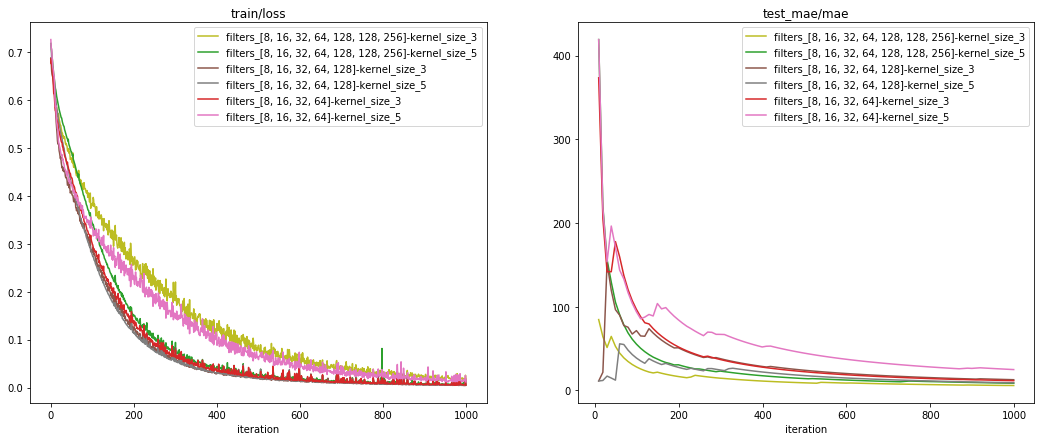

In [13]:
df = research.load_results(use_alias=True)
show_research(df, layout=['train/loss', 'test_mae/mae'], average_repetitions=True, color=list(mcolors.TABLEAU_COLORS.keys()))

Test metrics avaraged on the last 20 iterations.

In [16]:
z = print_results(df, 'test_mae/mae', True,ascending=True, n_last=20)
z

,test_mae_mean,test_mae_std
"filters_[8, 16, 32, 64, 128, 128, 256]-kernel_size_3",5.727922,0.038726
"filters_[8, 16, 32, 64, 128, 128, 256]-kernel_size_5",8.456002,0.058169
"filters_[8, 16, 32, 64, 128]-kernel_size_3",12.697358,0.088352
"filters_[8, 16, 32, 64, 128]-kernel_size_5",8.994951,0.062346
"filters_[8, 16, 32, 64]-kernel_size_3",11.506302,0.080525
"filters_[8, 16, 32, 64]-kernel_size_5",24.851517,0.175043


### Conclusion

We can see, that the best quality shows model with following parameters:
* _Number of Unet blocks_ - 7.
* _Kernel size_ - 3.